<a href="https://colab.research.google.com/github/arjun-mani/CNNWorkshop/blob/main/CNNWorkshop.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Computer Vision: Convolutional Neural Networks
## Author: Arjun Mani (arjuns@princeton.edu)

Sections:
* Motivation
* The Convolution Operation
* Architecture of Convolutional Neural Networks
* Building a CNN for Classifying Images
* Visualizing CNNs

In [81]:
!git clone https://github.com/arjun-mani/CNNWorkshop.git

fatal: destination path 'CNNWorkshop' already exists and is not an empty directory.


# Motivation

Convolutional neural networks are the backbone of modern image recognition systems. Our objective today is to understand how these models work and to actually implement them in practice. Let's start with the image below:

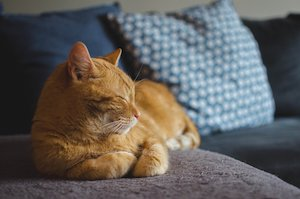

This image is a collection of RGB pixels. One thing that I could do is unroll the image into its pixel values and feed in this giant vector into a multilayer perceptron for prediction. We've covered MLPs in the previous workshop, but as a brief reminder these models consists of learned weight matrices *W* that multiply a large input vector *x*, i.e. performing the computation

*y = Wx + b.*

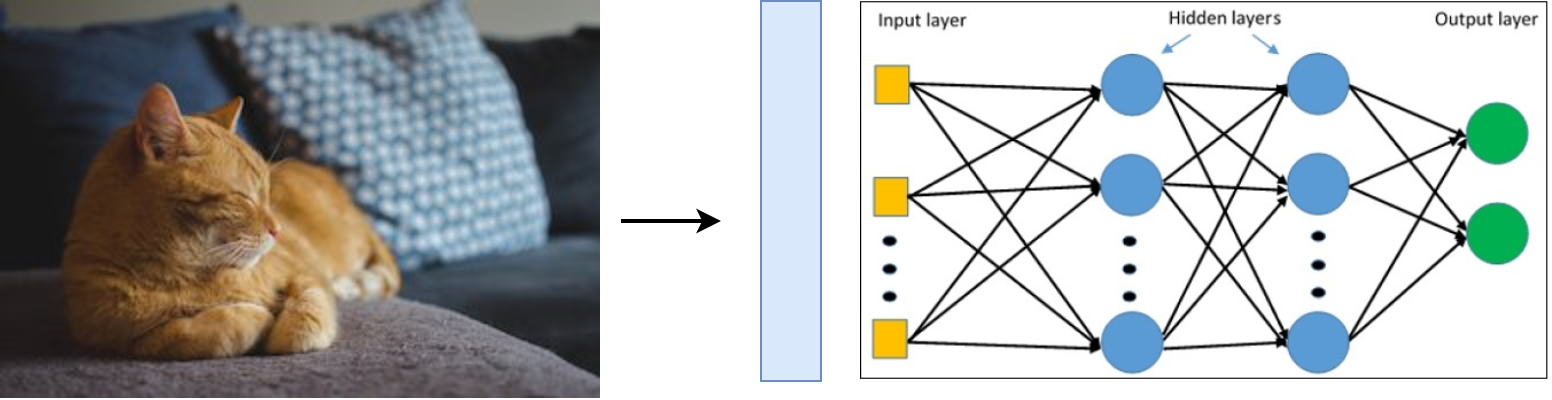

**Question**: why might unrolling the image into a collection of pixels be a bad strategy for analyzing images?

**Answer**: The order of pixels matters in an image. In other words, the fact that pixels are near each other in an image usually means that they make up some important part of the object (e.g. ear or leg). If we unroll the image then we treat it as an unordered collection of pixels, which loses a lot of information.

Clearly we don't want to lose this information. The underlying idea that motivates **Convolutional Neural Networks** is to take advantage of the spatial structure of an image. These models are actually inspired by the way that our own human visual cortex works! Our visual cortex is made up of "simple" cells that look for lines and shapes at specific positions and orientations, and "complex" cells that are not sensitive to position. Importantly, each cell in the visual cortex only looks at a certain portion of the visual field (the "receptive field"). In this way it takes into account the fact that the local structure of the image is important.

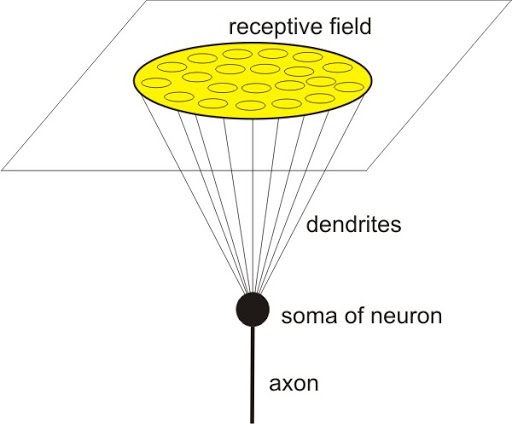

These cells are organized into hierarchies, for example a cell at the second level could see the output of simple cells at the first level. Thus cells deeper in the hierarchy can learn more complex feature on top of the simpler features learned by the earlier cells. This structure of our visual system, in particular the concepts of (1) local connectivity and (2) hierarchy directly motivate the design of convolutional neural networks.

# The Convolution Operation

Inspired by the human visual system, we might want to think about an operation that only "looks" at a certain part of the image. This operation can replace the matrix multiply operations that are currently in our neural network toolbox. It turns out that there is a well-suited operation called **convolution**! Convolution operations are the heart of CNNs, so let's try to understand what they do.

In a convolution operation, we have a filter that we scan across the input image. This filter is a small *n x n* matrix, much smaller than the *W x H* image. The filter is moved along the input and at each location we compute the dot product between the filter and the input. This is shown in the image below:

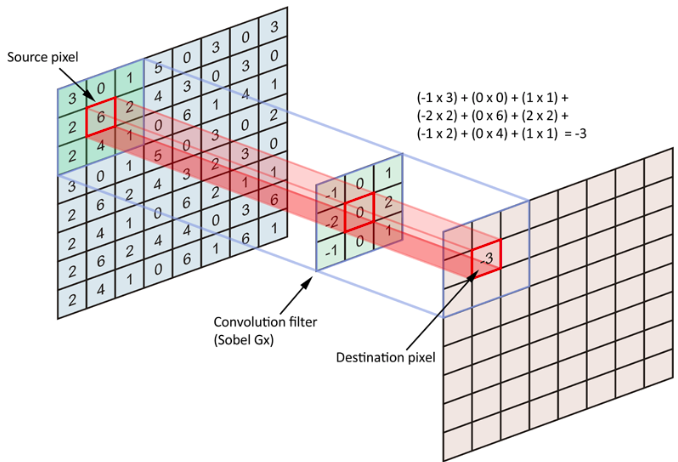

Note that at any given location a "neuron" in the output is only connected to a small region in the input. This "local connectivity" is essential to the structure of images, which is what makes convolutional operations effective. As a toy example to understand the power of convolutions - they can, for example, compute edges. Image convolving an image with a 3x3 filter where the left column has all 1s and the right column all -1s. This would have the highest response for points in the image with high contrast on the horizontal axis. This logic can be extended to construct filters that can actually do a pretty good job of detecting edges.

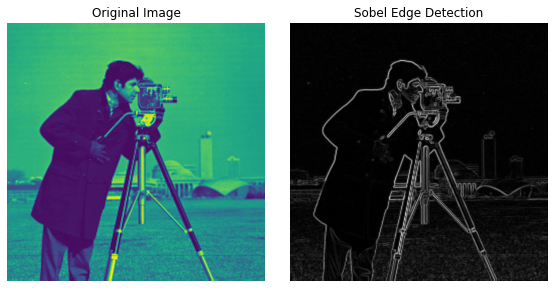

Hopefully this convinces you the power of convolutions and why we use them for images! The thing to keep remembering is that images have local structure and convolutions can exploit that. Now, how does convolution actually look like in real-life CNNs?

Well, we start with an RGB image, so the image is *W x H x 3*. So in reality the input image has a depth dimension, and the convolutional "filter" actually extends throughout the depth dimension. A particular "neuron" in the output is connected to an *n x n x D* region in the input, where *D* is the depth of the input. For example, we could slide a *5 x 5 * 3* convolutional filter across the input image, which would give us one 2D slice in the output. In a convolutional layer we actually learn many of these filters, and so the output of a convolutional layer is also 3D. Here's an animation, let's stare at it for a while together and it might make things clearer:

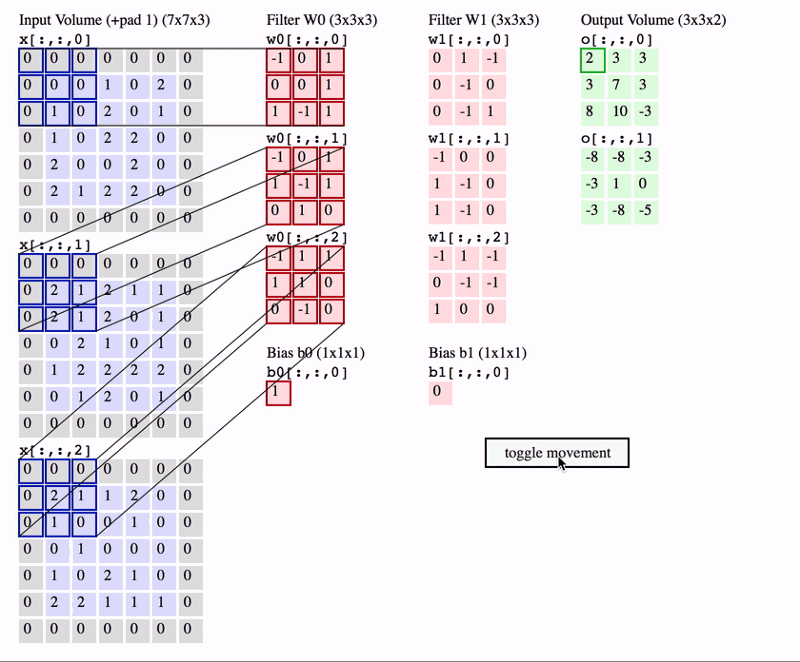

In the general case, the input to a convolutional layer is *W x H x N_in* and the output of the convolutional layer is *W' x H' x N_out*. The convolution layer learns *N_out* filters, each of them with dimension *n x n x N_in* such that they see a small spatial region of the input but extend through the entire depth of the input volume. Despite these details, the general principle still holds - a "neuron" in the output still only sees a small region in the input. 

Now, there are a bunch of hyperparameters that are worth mentioning, which control whether *W = W'*. For example how much do we slide the convolution over each time (what is the *stride* of the convolution?) Do we zero pad before performing the convolution? (the answer is usually yes). This is an example of a stride-1 convolution with zero padding:

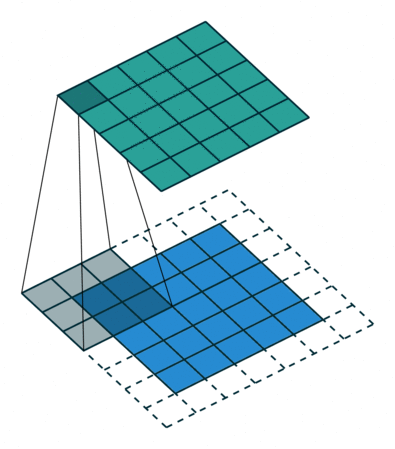

Another benefit of convolution you might notice at this point - we get to save on the number of parameters! If we had a fully-connected layer we would need a weight for every pixel value in the input. With convolution instead we only have *n x n* weights for the size of the filter, and we simply scan that across the input. So however large the size of the image is, our number of parameters stays the same.

The reason this works is that you can think of convolutions as doing some operation such as detecting edges or horizontal lines. If it is useful to detect edges in one part of the image, it stands to reason that it's probably useful to detect an edge in another part of the image. Therefore we can use the same filter for every location in the image.

In [ ]:
import torch
import torch.nn as nn
import cv2

img = torch.ones((1, 3, 6, 6))
print("Image shape")
print(img.shape)

conv2d = nn.Conv2d(in_channels=3, out_channels=2, kernel_size=5, stride=1, bias=False)

conv_img = conv2d(img)
print("No padding")
print(conv_img.shape)

# Add zero padding so that the output spatial dimension is the same
conv2dpad = nn.Conv2d(in_channels=3, out_channels=2, kernel_size=5, stride=1, padding=2, bias=False)
conv_img_pad = conv2dpad(img)
print("Padding")
print(conv_img_pad.shape)

# What's the shape of the weights of this layer?
print("Shape of convolutional layer weights")
print(conv2d.weight.shape)
print()

# Let's sanity-check that the convolution is doing the right thing
print("Input image")
print(img)
print("Weights of one 3D filter")
print(conv2d.weight[0])
print("Sanity-checking that we get the sum of weights in the output")
print(torch.sum(conv2d.weight[0]))
print(conv_img[0, 0])

## Backprop for Convolution

Recall that we train neural networks through backpropagation. Backpropagation computes the gradient of the loss/error with respect to all the weights in the model; the weights are then adjusted by gradient descent. How do we do backpropagation in convolution - in other words, how do we compute the gradient? It turns out that computing the gradient is also a convolution! Let's see how we can compute the gradient of the weights, starting by looking at the forward pass:

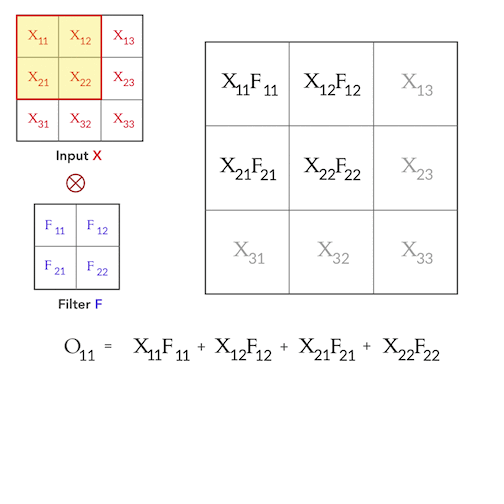

Then the gradient with respect to the filter weights can be computed as the following:

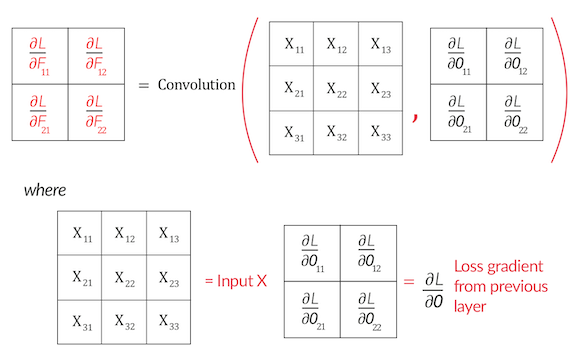

# Architecture of CNN models

The main component of CNNs are the convolutional layers we discussed above. However, there's more than just the conv layers. Let's say we're building a CNN for doing object recognition. A CNN architecture is made up of several convolutional "blocks". Each block consists of two components in addition to a convolutional layer: nonlinear activation, and pooling layer. The nonlinear activation serves the same job as in a regular neural network; it applies a nonlinear function to the input. 

The **pooling layer** downsamples the input. Typically this is implemented as a 2x2 max pooling; the maximum value of every non-overlapping 2x2 region in the input is taken, which reduces the image from *W x H* to *W/2 x H/2*. 

Why do we pool? The idea is to remain invariant to small distortions in the input. For example if I were to take an image of a digit and distort it slightly by moving a pixel up one position, max pooling on the image would still results in the same result. Here's what max pooling looks like:


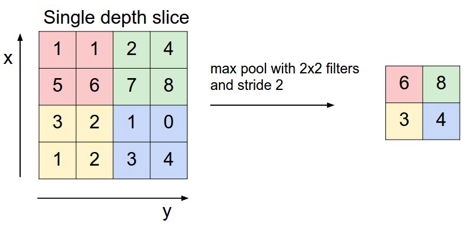

After a bunch of these convolutional blocks, we end up with some *w x h * N_out* feature representation, where *w* and *h* are pretty small and *N_out* is pretty large. We then flatten that into a giant vector and pass it through some fully-connected layers (our familiar matrix multiplies), finally predicting one of the possible object classes.

Basically a convolutional neural network consists of two parts:


1.  "Feature extractor": Passes image through a stack of convolutional and pooling layers to extract informative features about an image
2.   "Classifier": Pass these features through fully-connected layers and obtain predictions about the class of the object

This architecture is shown below. Note that after each convolutional layer the depth increases (since we usually learn more convolutional filters as go deeper in the network), and after each pooling layer the spatial dimension decreases (since we reduce each 2x2 region to a single value). Typical state-of-the-art architectures can contain five or more convolutional layers. Finally the output of the convolutional layers are flattened into a giant vector and passed into fully-connected layers for predicting the class of the image.

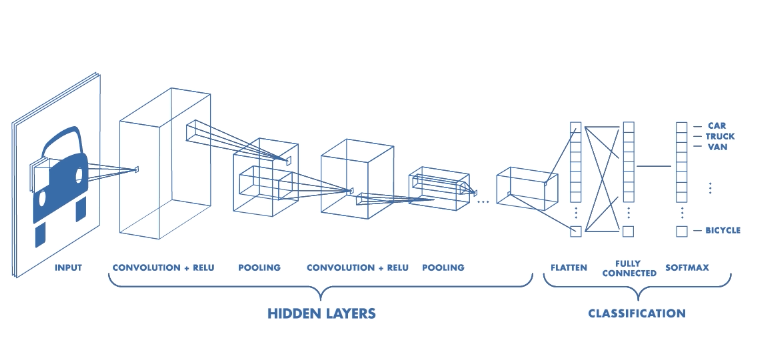

Let's look at how to build a simple conv-net architecture!

In [29]:
import torch.nn.functional as F

class SimpleConvNet(nn.Module):

  def __init__(self, n_classes):
    super(SimpleConvNet, self).__init__()

    self.conv1 = nn.Conv2d(3, 6, kernel_size=5)
    self.maxpool1 = nn.MaxPool2d(kernel_size=2)
    self.conv2 = nn.Conv2d(6, 16, kernel_size=5)
    self.maxpool2 = nn.MaxPool2d(kernel_size=2)
    self.fc1 = nn.Linear(16*5*5, 120)
    self.fc2 = nn.Linear(120, 84)
    self.fc3 = nn.Linear(84, 10)

  def forward(self, x):
      x = F.relu(self.conv1(x))
      x = self.maxpool1(x)
      x = F.relu(self.conv2(x))
      x = self.maxpool2(x)
      x = x.view(x.size(0), -1)
      x = F.relu(self.fc1(x))
      x = F.relu(self.fc2(x))
      x = self.fc3(x)
      return x

class SimpleConvNetPrint(nn.Module):

  def __init__(self, n_classes):
    super(SimpleConvNetPrint, self).__init__()

    self.conv1 = nn.Conv2d(3, 6, kernel_size=5)
    self.maxpool1 = nn.MaxPool2d(kernel_size=2)
    self.conv2 = nn.Conv2d(6, 16, kernel_size=5)
    self.maxpool2 = nn.MaxPool2d(kernel_size=2)
    self.fc1 = nn.Linear(16*5*5, 120)
    self.fc2 = nn.Linear(120, 84)
    self.fc3 = nn.Linear(84, 10)

  def forward(self, x):
      print("Initial shape")
      print(x.shape)
      x = F.relu(self.conv1(x))
      print("After first conv layer")
      print(x.shape)
      x = self.maxpool1(x)
      print("After first max pool")
      print(x.shape)
      x = F.relu(self.conv2(x))
      print("After second conv layer")
      print(x.shape)
      x = self.maxpool2(x)
      print("After second max pool")
      print(x.shape)
      x = x.view(x.size(0), -1)
      print("After flattening")
      print(x.shape)
      x = F.relu(self.fc1(x))
      print("After first FC layer")
      print(x.shape)
      x = F.relu(self.fc2(x))
      print("After second FC layer")
      print(x.shape)
      print("After third FC layer")
      x = self.fc3(x)
      print(x.shape)
      return x

In [ ]:
model = SimpleConvNet(n_classes=10)
print(model)

# How many parameters does the model have?
print("Number of parameters in model")
print(sum(p.numel() for p in model.parameters()))

In [ ]:
# Let's pass a dummy image through the model so that we understand exactly what's going on
model = SimpleConvNetPrint(n_classes=10)

dummy_img = torch.ones((1, 3, 32, 32))
out = model(dummy_img)

# Training our ConvNet on CIFAR-10

In this section we'll actually show you how to train the simple conv net we defined above on CIFAR-10. CIFAR-10 is a dataset of small 32x32 images that range across ten classes (e.g. car, plane, frog, etc.) The goal is to identify the object given the image. 

In [ ]:
from torch.utils.data import DataLoader
import torchvision
from torchvision import datasets, transforms

transform = transforms.Compose([transforms.ToTensor()])

train_set = torchvision.datasets.CIFAR10(root='./data', train=True, download=True, transform=transform)
train_loader = torch.utils.data.DataLoader(dataset=train_set, batch_size=32, shuffle=True)

test_set = torchvision.datasets.CIFAR10(root='./data', train=False, download=True, transform=transform)
test_loader = torch.utils.data.DataLoader(dataset=test_set, batch_size=32, shuffle=False)

#Class labels
classes = ('Airplane', 'Car', 'Bird', 'Cat', 'Deer', 'Dog', 'Frog', 'Horse', 'Ship', 'Truck')

In [ ]:
import matplotlib.pyplot as plt
import numpy as np

#Function to show some random images
def imshow(img):
    img = img / 2 + 0.5     # unnormalize
    npimg = img.numpy()
    plt.imshow(np.transpose(npimg, (1, 2, 0)))
    plt.show()

#Get some random training images
dataiter = iter(train_loader)
images, labels = dataiter.next()

#Show images
imshow(torchvision.utils.make_grid(images))
# print labels
print(' '.join('%5s' % classes[labels[j]] for j in range(4)))

In [66]:
class BiggerConvNet(nn.Module):

  def __init__(self, n_classes):
    super(BiggerConvNet, self).__init__()

    self.conv1 = nn.Conv2d(3, 48, kernel_size=3, padding=1)
    self.conv2 = nn.Conv2d(48, 48, kernel_size=3, padding=1)
    self.maxpool1 = nn.MaxPool2d(kernel_size=2)
    self.conv3 = nn.Conv2d(48, 96, kernel_size=3, padding=1)
    self.conv4 = nn.Conv2d(96, 96, kernel_size=3, padding=1)
    self.maxpool2 = nn.MaxPool2d(kernel_size=2)
    self.fc1 = nn.Linear(96*8*8, 120)
    self.fc2 = nn.Linear(120, 84)
    self.fc3 = nn.Linear(84, 10)

  def forward(self, x):
      x = F.relu(self.conv1(x))
      x = F.relu(self.conv2(x))
      x = self.maxpool1(x)
      x = F.relu(self.conv3(x))
      x = F.relu(self.conv4(x))
      x = self.maxpool2(x)
      x = x.view(x.size(0), -1)
      x = F.relu(self.fc1(x))
      x = F.relu(self.fc2(x))
      x = self.fc3(x)
      return x

In [ ]:
# For using the GPU
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
# Verifying CUDA device is available
print(device)

my_model = BiggerConvNet(n_classes=10)
# If possible, moves training over to GPU/TPU. Otherwise defaults to CPU
my_model.to(device)


# Define loss and optimizer
import torch.optim as optim
#Loss
criterion = nn.CrossEntropyLoss()
#Optimizer(SGD)
optimizer = optim.SGD(my_model.parameters(), lr=0.001, momentum=0.9)

In [ ]:
for epoch in range(20):  # loop over the dataset multiple times
    running_loss = 0.0
    for i, data in enumerate(train_loader, 0):
        # get the inputs; data is a list of [inputs, labels]
        inputs, labels = data[0].to(device), data[1].to(device)

        # zero the parameter gradients
        optimizer.zero_grad()

        # forward + backward + optimize
        output = my_model(inputs)
        loss = criterion(output, labels)
        loss.backward()
        optimizer.step()

        running_loss += loss.item()

    print('Epoch %d: loss: %.3f' % (epoch + 1, running_loss / len(train_loader)))
            
print('Finished Training of Model')
 

In [ ]:
#Testing Accuracy
correct = 0
total = 0
with torch.no_grad():
    for data in test_loader:
        images, labels = data[0].to(device), data[1].to(device)
        outputs = my_model(images)
        loss = criterion(outputs, labels)
        _, predicted = torch.max(outputs.data, 1)
        total += labels.size(0)
        correct += (predicted == labels).sum().item()

print('Accuracy of the network on the 10000 test images: %f %%' % (
    100 * correct / total))
print('Loss of network on the 10000 test images: %f' % (loss))

# Visualizing CNNs

CNNs are commonly called "black boxes" because we don't know exactly what they're learning about images. However, we can actually try to dive into the inner workings of the network and get a sense of what these models are learning. Let's do a bit of that before we wrap up, using the state-of-the-art VGG-16 model.

In [ ]:
R50 = models.resnet50(pretrained=True)
print(R50)

# How many parameters does the model have?
print("Number of parameters in model")
print(sum(p.numel() for p in R50.parameters()))

In [ ]:
model_weights = [] # we will save the conv layer weights in this list
conv_layers = [] # we will save the 49 conv layers in this list
# get all the model children as list
model_children = list(R50.children())

# counter to keep count of the conv layers
counter = 0 
# append all the conv layers and their respective weights to the list
for i in range(len(model_children)):
    if type(model_children[i]) == nn.Conv2d:
        counter += 1
        model_weights.append(model_children[i].weight)
        conv_layers.append(model_children[i])
    elif type(model_children[i]) == nn.Sequential:
        for j in range(len(model_children[i])):
            for child in model_children[i][j].children():
                if type(child) == nn.Conv2d:
                    counter += 1
                    model_weights.append(child.weight)
                    conv_layers.append(child)
print(f"Total convolutional layers: {counter}")

In [ ]:
# visualize the first conv layer filters
plt.figure(figsize=(20, 17))
for i, filter in enumerate(model_weights[0]):
    plt.subplot(8, 8, i+1) # (8, 8) because in conv0 we have 7x7 filters and total of 64 (see printed shapes)
    plt.imshow(filter[0, :, :].detach(), cmap='gray')
    plt.axis('off')
plt.show()

In [ ]:
img = cv2.imread("./CNNWorkshop/cat.jpeg")
img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
plt.imshow(img)
plt.show()
# define the transforms
transform = transforms.Compose([
    transforms.ToPILImage(),
    transforms.Resize((512, 512)),
    transforms.ToTensor(),
])
img = np.array(img)
# apply the transforms
img = transform(img)
print(img.size())
# unsqueeze to add a batch dimension
img = img.unsqueeze(0)
print(img.size())

In [53]:
# pass the image through all the layers
results = [conv_layers[0](img)]
for i in range(1, len(conv_layers)):
    # pass the result from the last layer to the next layer
    results.append(conv_layers[i](results[-1]))
# make a copy of the `results`
outputs = results

In [ ]:
# visualize 64 features from each layer 
# (although there are more feature maps in the upper layers)
for num_layer in range(len(outputs)):
    plt.figure(figsize=(30, 30))
    layer_viz = outputs[num_layer][0, :, :, :]
    layer_viz = layer_viz.data
    print(layer_viz.size())
    for i, filter in enumerate(layer_viz):
        if i == 64: # we will visualize only 8x8 blocks from each layer
            break
        plt.subplot(8, 8, i + 1)
        plt.imshow(filter, cmap='gray')
        plt.axis("off")
    print(f"Saving layer {num_layer} feature maps...")
    plt.show()
    break
    plt.close()

There are other ways to visualize what a CNN is doing. For example the magnitude of the gradients give us a rough notion of "which pixels in the input are most important to the model". This idea actually allows us to build heatmaps. For a given class prediction, we can backpropagate to find the locations in the image with the highest gradients from that prediction, which tell us which regions of the image were most influential for the prediction. This allows us to generate heatmaps like this:

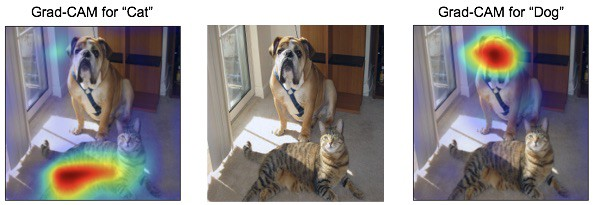

And that's a wrap! Hope you enjoyed the workshop. Please fill out the feedback form here, it's always super helpful for us: https://forms.gle/vUDTchhzCxXu3iA1A